In [47]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.initializers import RandomNormal
from keras.layers.normalization import BatchNormalization
from keras import regularizers

In [2]:
#Drop any songs that have NaN as a genre
genres = pd.read_csv('fma_metadata/tracks.csv', low_memory=False).dropna(subset=['track.7'])
genres = genres.rename(index=str, columns={'Unnamed: 0': 'id', 'track.7': 'genre'})
#Reduce size of df to just id and genre
genres = genres[['id', 'genre']]
#Get 25,000 of the songs that don't have NaN as a genre
genres = genres[1:].sample(25000)
genres = genres.set_index('id')
features = pd.read_csv('fma_metadata/features.csv', low_memory=False)
features = features.rename(index=str, columns={'feature': 'id'})
#filter out the same track IDs
features = features.loc[features.id.isin(genres.index.values)].set_index('id')
features.reindex(genres.index.values)
features = features.merge(genres, on='id')

In [3]:
scaler = StandardScaler()
training_set = features[:22427]
test_set = features[22427:]
train_X = training_set.drop('genre', axis=1)
train_X = scaler.fit_transform(train_X)
train_Y = training_set['genre'].values
test_X = scaler.transform(test_set.drop('genre', axis=1))
test_Y = test_set['genre'].values

onehot_encoder = OneHotEncoder(sparse=False)
train_Y = train_Y.reshape(len(train_Y), 1)
train_Y = onehot_encoder.fit_transform(train_Y)
test_Y = test_Y.reshape(len(test_Y), 1)
test_Y = onehot_encoder.transform(test_Y)



C:\Users\Public\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  import sys


In [4]:
pca = PCA(n_components=300)
train_X = pca.fit_transform(train_X)
test_X = pca.transform(test_X)

In [52]:
#Weight initilizers as recommended in http://cs231n.github.io/neural-networks-2/
model = Sequential()
model.add(Dropout(0.25))
model.add(Dense(units=320, input_dim=len(pca.explained_variance_), 
                kernel_regularizer=regularizers.l2(0.01),
                kernel_initializer=RandomNormal(stddev=np.sqrt(2/len(pca.explained_variance_)))))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(units=32, 
                kernel_regularizer=regularizers.l2(0.01),
                kernel_initializer=RandomNormal(stddev=np.sqrt(2/320))))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(units=16, 
               kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('softmax'))
opt = SGD(lr=0.001, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [53]:
history = model.fit(train_X, train_Y, epochs=300, batch_size=200, validation_split=0.3)

Train on 15698 samples, validate on 6729 samples
Epoch 1/300
15698/15698 [==============================] - 2s 148us/step - loss: 10.2716 - acc: 0.0740 - val_loss: 9.7384 - val_acc: 0.1491
Epoch 2/300
15698/15698 [==============================] - 1s 39us/step - loss: 9.7004 - acc: 0.1567 - val_loss: 9.2991 - val_acc: 0.3020
Epoch 3/300
15698/15698 [==============================] - 1s 39us/step - loss: 9.2658 - acc: 0.2433 - val_loss: 8.9362 - val_acc: 0.3656
Epoch 4/300
15698/15698 [==============================] - 1s 38us/step - loss: 8.8913 - acc: 0.3104 - val_loss: 8.6308 - val_acc: 0.3986
Epoch 5/300
15698/15698 [==============================] - 1s 39us/step - loss: 8.5784 - acc: 0.3535 - val_loss: 8.3533 - val_acc: 0.4155
Epoch 6/300
15698/15698 [==============================] - 1s 39us/step - loss: 8.2723 - acc: 0.3943 - val_loss: 8.1010 - val_acc: 0.4249
Epoch 7/300
15698/15698 [==============================] - 1s 39us/step - loss: 8.0140 - acc: 0.4112 - val_loss: 7.8605 -

15698/15698 [==============================] - 1s 39us/step - loss: 2.5167 - acc: 0.5766 - val_loss: 2.5793 - val_acc: 0.5631
Epoch 60/300
15698/15698 [==============================] - 1s 39us/step - loss: 2.4739 - acc: 0.5752 - val_loss: 2.5394 - val_acc: 0.5671
Epoch 61/300
15698/15698 [==============================] - 1s 39us/step - loss: 2.4307 - acc: 0.5764 - val_loss: 2.4980 - val_acc: 0.5690
Epoch 62/300
15698/15698 [==============================] - 1s 39us/step - loss: 2.3978 - acc: 0.5796 - val_loss: 2.4668 - val_acc: 0.5664
Epoch 63/300
15698/15698 [==============================] - 1s 39us/step - loss: 2.3530 - acc: 0.5847 - val_loss: 2.4377 - val_acc: 0.5628
Epoch 64/300
15698/15698 [==============================] - 1s 40us/step - loss: 2.3247 - acc: 0.5822 - val_loss: 2.4035 - val_acc: 0.5662
Epoch 65/300
15698/15698 [==============================] - 1s 39us/step - loss: 2.2915 - acc: 0.5792 - val_loss: 2.3664 - val_acc: 0.5693
Epoch 66/300
15698/15698 [==============

Epoch 118/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.3360 - acc: 0.6404 - val_loss: 1.5491 - val_acc: 0.5879
Epoch 119/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.3260 - acc: 0.6405 - val_loss: 1.5048 - val_acc: 0.5950
Epoch 120/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.3205 - acc: 0.6404 - val_loss: 1.5135 - val_acc: 0.5895
Epoch 121/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.3086 - acc: 0.6475 - val_loss: 1.5195 - val_acc: 0.5901
Epoch 122/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.3024 - acc: 0.6498 - val_loss: 1.5148 - val_acc: 0.5931
Epoch 123/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.2934 - acc: 0.6507 - val_loss: 1.5324 - val_acc: 0.5842
Epoch 124/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.2934 - acc: 0.6465 - val_loss: 1.5117 - val_acc: 0.5875
Epoch 125/300
15698/

15698/15698 [==============================] - 1s 38us/step - loss: 1.1307 - acc: 0.6749 - val_loss: 1.4711 - val_acc: 0.5873
Epoch 177/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.1399 - acc: 0.6743 - val_loss: 1.4184 - val_acc: 0.6014
Epoch 178/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.1412 - acc: 0.6726 - val_loss: 1.4782 - val_acc: 0.5864
Epoch 179/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.1420 - acc: 0.6763 - val_loss: 1.4859 - val_acc: 0.5799
Epoch 180/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.1317 - acc: 0.6765 - val_loss: 1.4591 - val_acc: 0.5909
Epoch 181/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.1371 - acc: 0.6757 - val_loss: 1.4405 - val_acc: 0.5922
Epoch 182/300
15698/15698 [==============================] - 1s 39us/step - loss: 1.1267 - acc: 0.6728 - val_loss: 1.4559 - val_acc: 0.5915
Epoch 183/300
15698/15698 [=======

15698/15698 [==============================] - 1s 38us/step - loss: 1.1143 - acc: 0.6856 - val_loss: 1.4848 - val_acc: 0.5876
Epoch 235/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.1196 - acc: 0.6819 - val_loss: 1.4641 - val_acc: 0.5918
Epoch 236/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.1041 - acc: 0.6836 - val_loss: 1.4814 - val_acc: 0.5867
Epoch 237/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.1031 - acc: 0.6879 - val_loss: 1.4589 - val_acc: 0.5861
Epoch 238/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.1092 - acc: 0.6845 - val_loss: 1.4767 - val_acc: 0.5858
Epoch 239/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.1062 - acc: 0.6850 - val_loss: 1.4980 - val_acc: 0.5839
Epoch 240/300
15698/15698 [==============================] - 1s 39us/step - loss: 1.1151 - acc: 0.6856 - val_loss: 1.4859 - val_acc: 0.5944
Epoch 241/300
15698/15698 [=======

15698/15698 [==============================] - 1s 39us/step - loss: 1.0986 - acc: 0.6915 - val_loss: 1.5266 - val_acc: 0.5839
Epoch 293/300
15698/15698 [==============================] - 1s 39us/step - loss: 1.0880 - acc: 0.6962 - val_loss: 1.5134 - val_acc: 0.5891
Epoch 294/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.1024 - acc: 0.6910 - val_loss: 1.5190 - val_acc: 0.5883
Epoch 295/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.0912 - acc: 0.6938 - val_loss: 1.5016 - val_acc: 0.5883
Epoch 296/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.0953 - acc: 0.6895 - val_loss: 1.5217 - val_acc: 0.5863
Epoch 297/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.0776 - acc: 0.6968 - val_loss: 1.5020 - val_acc: 0.5897
Epoch 298/300
15698/15698 [==============================] - 1s 38us/step - loss: 1.0892 - acc: 0.6981 - val_loss: 1.4792 - val_acc: 0.5950
Epoch 299/300
15698/15698 [=======

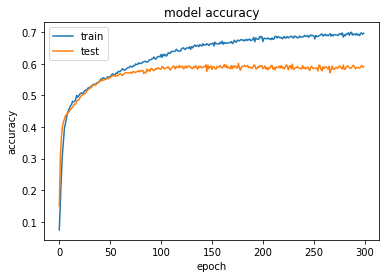

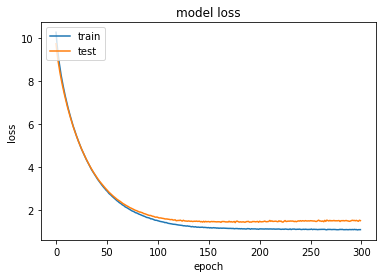

In [54]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
model.evaluate(test_X, test_Y)

2573/2573 [==============================] - 0s 52us/step


[1.335788596107299, 0.6490478041312874]